In [29]:
import json
import shutil
import nglview
import requests
import upsetplot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from pathlib import Path
import ipywidgets as widgets
import matplotlib_venn as venn
import matplotlib.pyplot as plt
from IPython.display import IFrame, Image, SVG
from IPython.display import set_matplotlib_formats

In [30]:
set_matplotlib_formats('svg')
mpl.rcParams['figure.dpi'] = 150

In [31]:
disprot = json.load(open("data_big/disprot8.json"))

In [32]:
d2u_f = Path("data/disprot2uniprot.json")

def make_disprot2uniprot(outpath):
    disprot2uniprot = {}
    for entry in disprot['data']:
        disprot2uniprot[entry['disprot_id']] = entry['acc']
        
    with open(outpath, "w") as f:
        json.dump(disprot2uniprot, f)
    
    return disprot2uniprot

disprot2uniprot = json.load(open(d2u_f)) if d2u_f.is_file() else make_disprot2uniprot(d2u_f)
uniprot2disprot = {v: k for k, v in disprot2uniprot.items()}

In [33]:
def make_pos_serializable(pos):
    for k in pos:
        for a in pos[k]:
            pos[k][a] = list(pos[k][a])
    return pos


def deserialize_pos(pos):
    for k in pos:
        for a in pos[k]:
            pos[k][a] = set(pos[k][a])
    return pos


def load_pos(inpath):
    with open(inpath) as f:
        return deserialize_pos(json.load(f))

In [34]:
dpos_f = Path("data/disprot_positions.json")

def make_idtr_pos(outpath):
    id_pos = {}
    tr_pos = {}
    for entry in disprot['data']:
        acc = entry['acc']
        id_pos[acc] = set()
        tr_pos[acc] = set()
        
        for region in entry['regions']:
            if region['term_namespace'] == 'Structural state' and region['term_name'] != 'Order':
                id_pos[acc].update(set(range(region['start'], region['end'] + 1)))
            elif region['term_namespace'] == 'Structural transition':
                tr_pos[acc].update(set(range(region['start'], region['end'] + 1)))
    
    pos = {"id": id_pos, "tr": tr_pos}
    
    with open(outpath, "w") as f:
        json.dump(make_pos_serializable(pos), f)
    
    return deserialize_pos(pos)


disprot_pos = load_pos(dpos_f) if dpos_f.is_file() else make_idtr_pos(dpos_f)

In [35]:
ppos_f = Path("data/pdb_positions.json")
len_f = Path("data/length.json")

def make_st_pos_and_length(outpath_pos, outpath_len):
    st_pos = {}
    length = {}

    for updbs in Path('/mnt/projects/mobidb3.1/data/mobi2/protein_complex').iterdir():
        acc = updbs.stem
        if acc in disprot_pos["id"]:
            st_pos[acc] = set()

            with open(updbs) as f:
                updbs = json.load(f)
                length[acc] = len(updbs['sequence'])
                for method in updbs['mobidb_consensus']['disorder']['derived']:
                    for region in method['regions']:
                        if region[-1].upper() in {'S', 'C'}:
                            st_pos[acc].update(set(range(region[0], region[1] + 1)))
                            
    
    pos = {"st": st_pos}
        
    with open(outpath_pos, "w") as fp, open(outpath_len, "w") as fl:
        json.dump(make_pos_serializable(pos), fp)
        json.dump(length, fl)
    
    return deserialize_pos(pos), length

p, l = make_st_pos_and_length(ppos_f, len_f)
pdb_pos = load_pos(ppos_f) if ppos_f.is_file() else p
length = json.load(open(len_f)) if len_f.is_file() else l

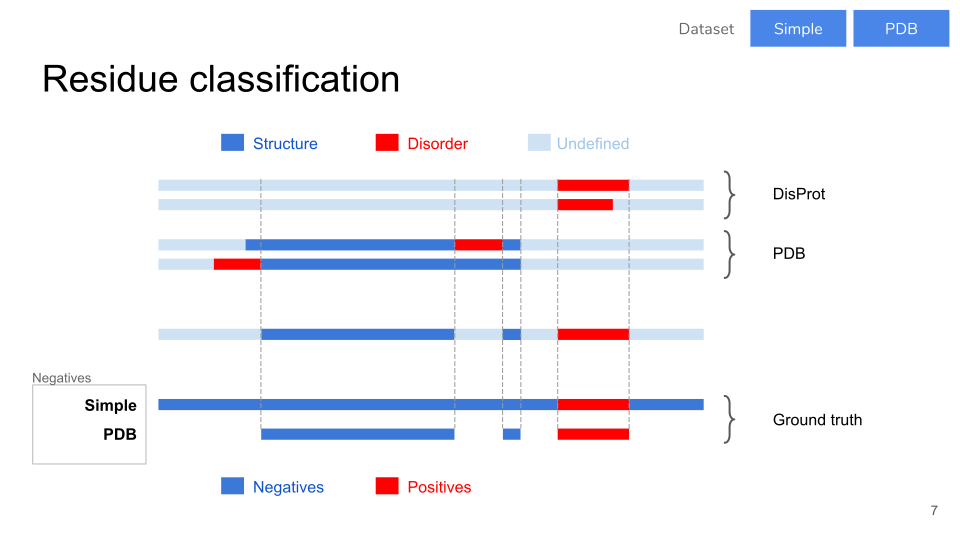

In [65]:
display(SVG(filename="data/caidnegs.svg"))

In [36]:
pos = {**pdb_pos, **disprot_pos}

[d3-dendogram/index.html](d3-dendogram/index.html)

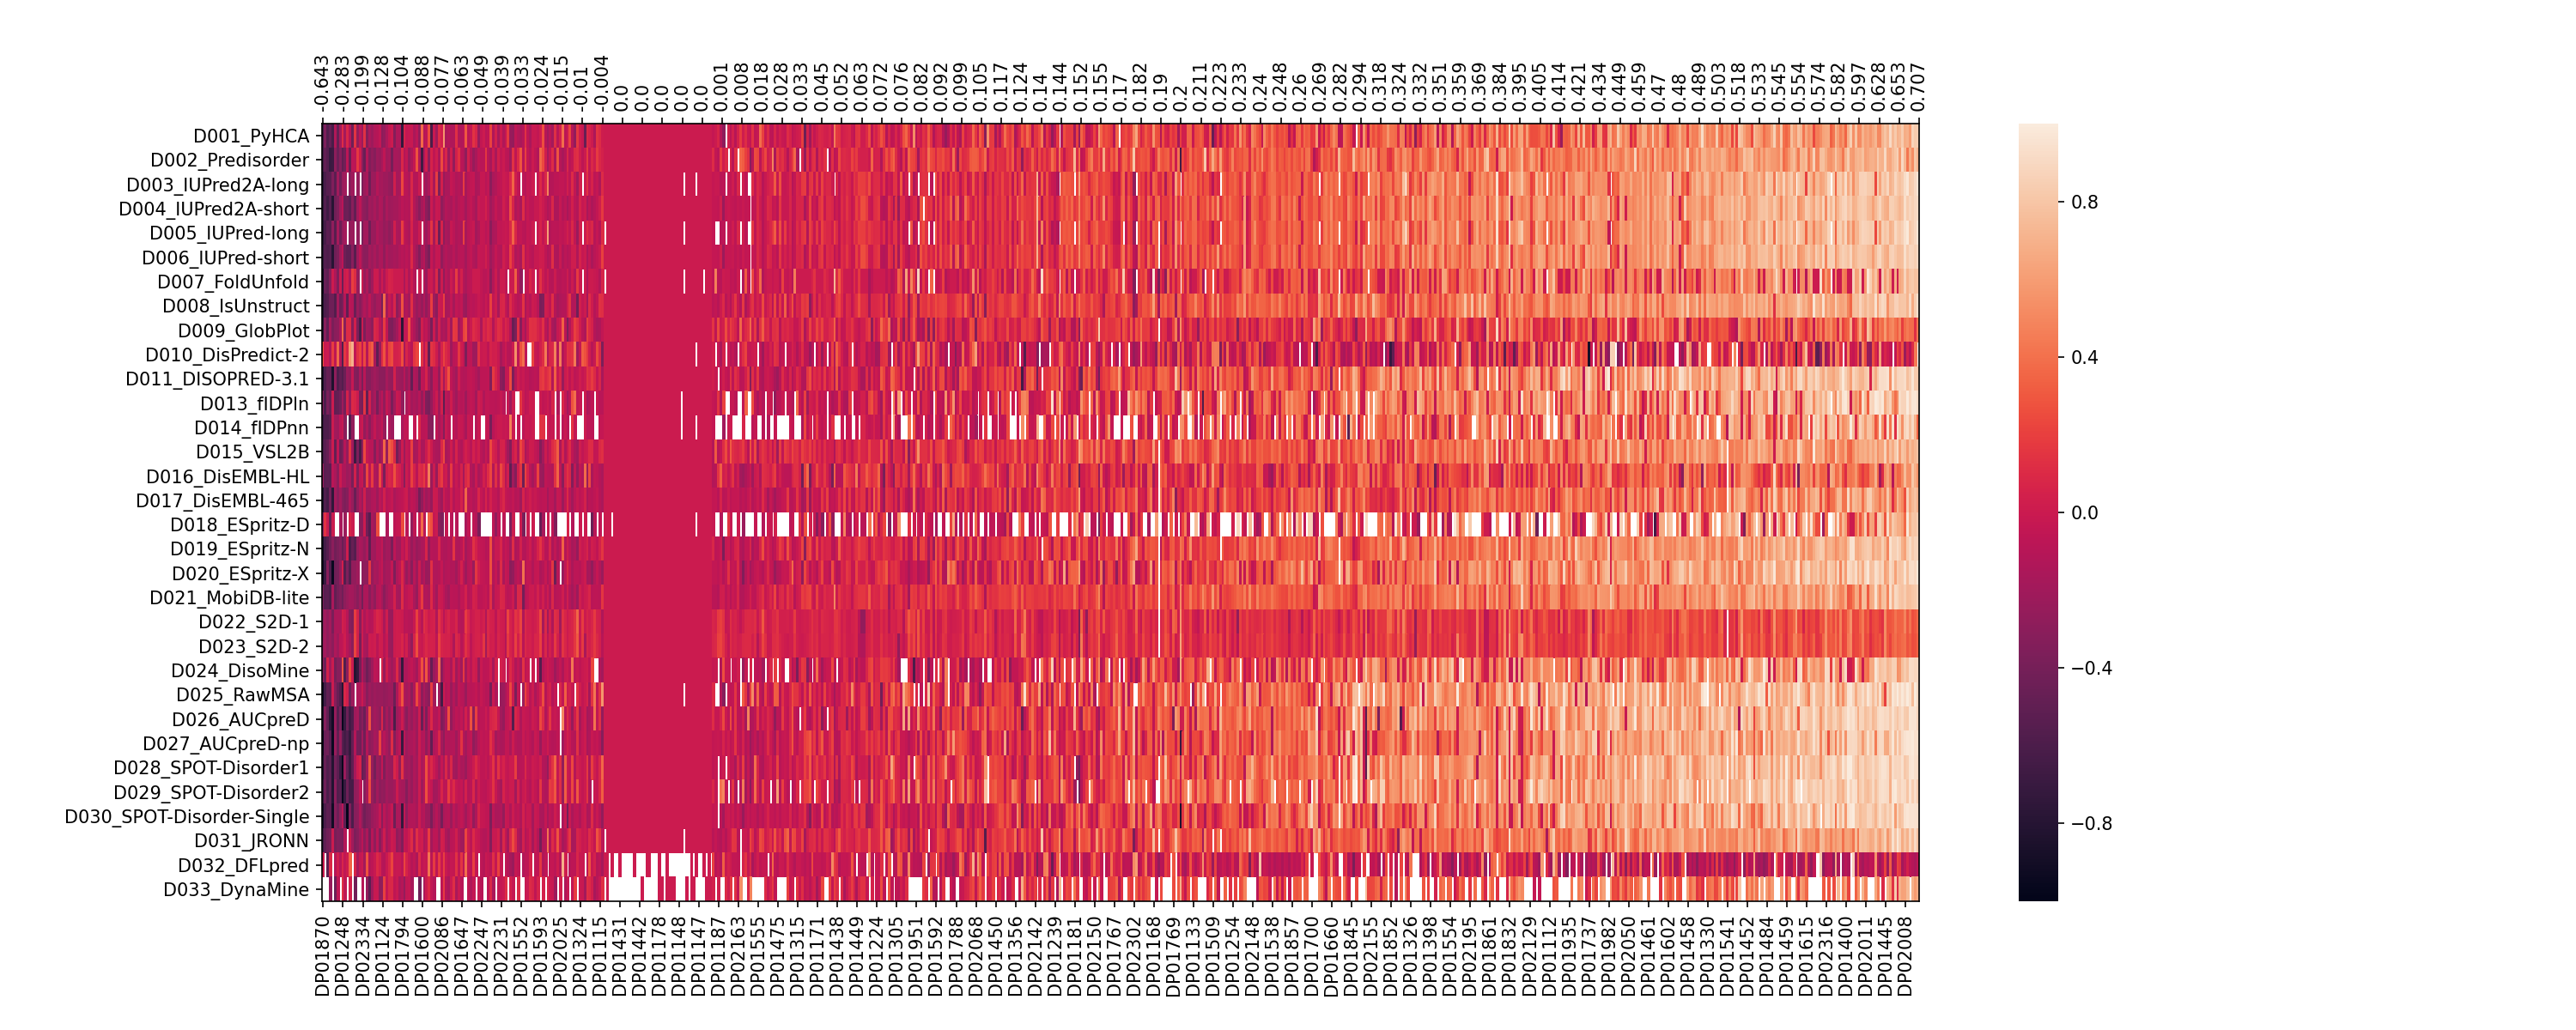

In [64]:
display(Image(filename="data/targetmcc.png", height="100%"))

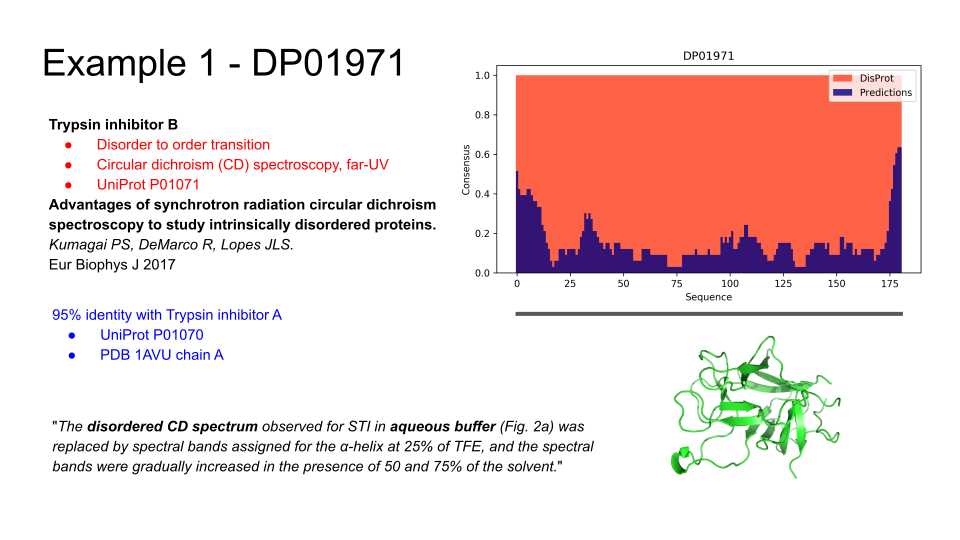

In [59]:
display(SVG(filename="data/DP01971.svg"))

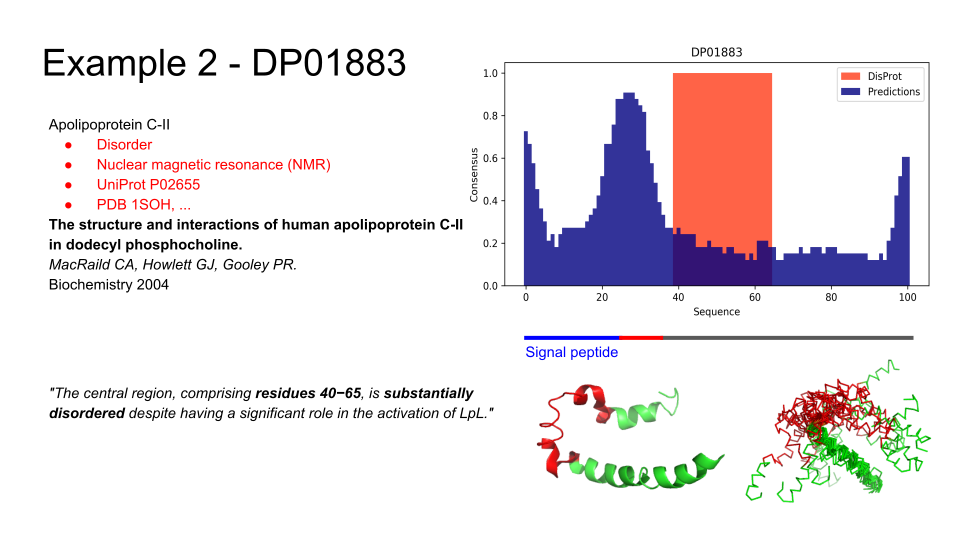

In [58]:
display(SVG(filename="data/DP01883.svg"))

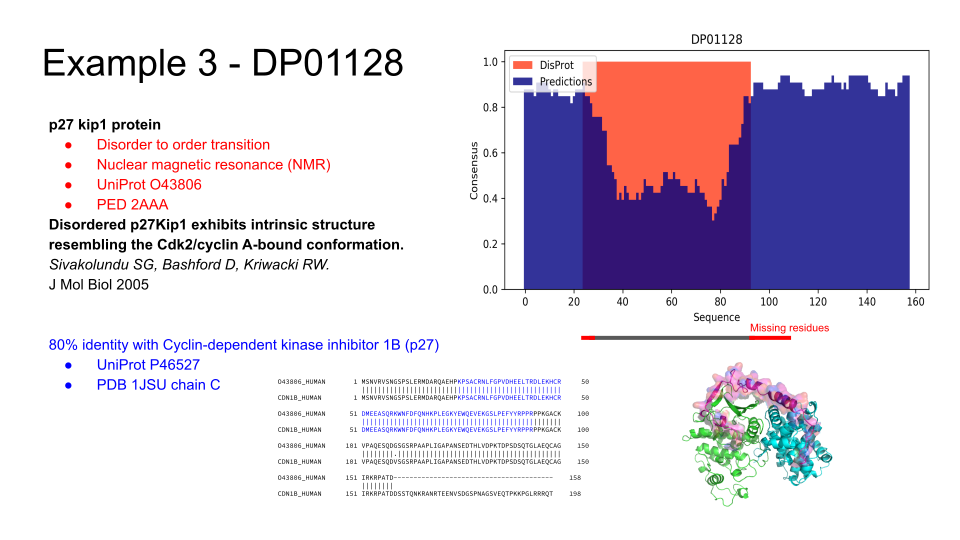

In [57]:
display(SVG(filename="data/DP01128.svg"))

In [38]:
with open("data/neg_mcc.json") as f:
    neg_mcc = {disprot2uniprot[e] for e in json.load(f) if e in disprot2uniprot}

In [39]:
def build_overlap_table():
    overlap_table = {}
    for entry in length:
    
        for res_idx in range(1, length[entry] + 1):
            overlap_table[(entry, res_idx)] = {'id': 0, 'st': 0, 'tr': 0, 'id+st': 0, 'id+st+tr': 0, 'id+tr': 0, 'st+tr': 0, 'ido': 0, 'sto': 0, 'tro': 0, '(id+st)o': 0}
            # if disorder state
            if res_idx in pos["id"][entry]:
                overlap_table[(entry, res_idx)]['id'] = 1

                # and in pdb
                if res_idx in pos["st"][entry]:
                    overlap_table[(entry, res_idx)]['id+st'] = 1
                    # and in transition
                    if res_idx in pos["tr"][entry]:
                        overlap_table[(entry, res_idx)]['id+st+tr'] = 1
                    else:
                        overlap_table[(entry, res_idx)]['(id+st)o'] = 1

                # and in transition
                if res_idx in pos["tr"][entry]:
                    overlap_table[(entry, res_idx)]['id+tr'] = 1

                # but not in pdb and transition
                if res_idx not in pos["st"][entry] and res_idx not in pos["tr"][entry]:
                        overlap_table[(entry, res_idx)]['ido'] = 1

            # if in pdb
            if res_idx in pos["st"][entry]:
                overlap_table[(entry, res_idx)]['st'] = 1
                # and in transition
                if res_idx in pos["tr"][entry]:
                    overlap_table[(entry, res_idx)]['st+tr'] = 1
                # but not in disorder state and transtion
                if res_idx not in pos["id"][entry] and res_idx not in pos["tr"][entry]:
                        overlap_table[(entry, res_idx)]['sto'] = 1

            # if in transition
            if res_idx in pos["tr"][entry]:
                overlap_table[(entry, res_idx)]['tr'] = 1
                # but not in disorder state and pdb
                if res_idx not in pos["id"][entry] and res_idx not in pos["st"][entry]:
                        overlap_table[(entry, res_idx)]['tro'] = 1

    return overlap_table

In [40]:
overlap_f = Path("data_big/overlap.csv")

def make_overlap_df(outpath):
    df = pd.DataFrame.from_dict(build_overlap_table(), orient='index')
    df.to_csv(outpath)
    return df

overlap_df = pd.read_csv(overlap_f, index_col=[0, 1], header=[0]) if overlap_f.is_file() else make_overlap_df(overlap_f)
overlap_df

id  st  tr  id+st  id+st+tr  id+tr  st+tr  ido  sto  tro  (id+st)o
Q00955 1     0   0   0      0         0      0      0    0    0    0         0
       2     0   0   0      0         0      0      0    0    0    0         0
       3     0   0   0      0         0      0      0    0    0    0         0
       4     0   0   0      0         0      0      0    0    0    0         0
       5     0   0   0      0         0      0      0    0    0    0         0
...         ..  ..  ..    ...       ...    ...    ...  ...  ...  ...       ...
P21246 164   1   1   0      1         0      0      0    0    0    0         1
       165   1   1   0      1         0      0      0    0    0    0         1
       166   1   1   0      1         0      0      0    0    0    0         1
       167   1   1   0      1         0      0      0    0    0    0         1
       168   1   1   0      1         0      0      0    0    0    0         1

[642076 rows x 11 columns]

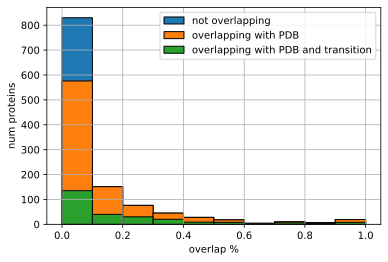

In [41]:
def plot_overlap_distrib():
    idst_p = overlap_df.groupby(level=0)['id+st'].mean()
    idsttr_p = overlap_df.groupby(level=0)['id+st+tr'].mean()

    _, bins = np.histogram(idst_p.values.T)
    idst_p_true = idst_p[idst_p > 0]
    idsttr_p_true = idsttr_p[idsttr_p > 0]

    ax = idst_p.hist(edgecolor='k', bins=bins, label='not overlapping')
    ax = idst_p_true.hist(edgecolor='k', bins=bins, label='overlapping with PDB')
    ax = idsttr_p_true.hist(edgecolor='k',bins=bins, label='overlapping with PDB and transition')
    ax.set_ylabel("num proteins")
    ax.set_xlabel("overlap %")
    plt.legend();


plot_overlap_distrib()

In [42]:
o = widgets.FloatSlider(
    value=0,
    min=0,
    max=1,
    step=0.01,
    description='Min Overlap',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

In [43]:
idst_p = overlap_df.groupby(level=0)["id+st"].mean()
id_p = overlap_df.groupby(level=0)['id'].mean()
st_p = overlap_df.groupby(level=0)['st'].mean()
idsttr_p = overlap_df["id+st+tr"].groupby(level=0).mean()
overlap_p = overlap_df.groupby(level=0).mean()

In [44]:
overlap_df.groupby(level=0).mean().round(2)

,id,st,tr,id+st,id+st+tr,id+tr,st+tr,ido,sto,tro,(id+st)o
A0A060ZAA1,0.41,0.41,0.0,0.41,0.0,0.0,0.0,0.00,0.00,0.0,0.41
A0A0H3CFC9,0.36,0.54,0.0,0.00,0.0,0.0,0.0,0.36,0.54,0.0,0.00
A0A0H3LBR3,0.19,0.85,0.0,0.10,0.0,0.0,0.0,0.09,0.75,0.0,0.10
A0A0J9X1Q5,0.02,0.54,0.0,0.00,0.0,0.0,0.0,0.02,0.54,0.0,0.00
A0A140GKJ0,0.38,0.62,0.0,0.00,0.0,0.0,0.0,0.38,0.62,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...
Q9Z1X4,0.11,0.52,0.0,0.00,0.0,0.0,0.0,0.10,0.51,0.0,0.00
Q9Z2F5,0.20,0.78,0.0,0.00,0.0,0.0,0.0,0.20,0.78,0.0,0.00
Q9Z8L4,0.27,0.73,0.0,0.00,0.0,0.0,0.0,0.27,0.73,0.0,0.00
Q9ZLR7,0.25,0.67,0.0,0.00,0.0,0.0,0.0,0.25,0.67,0.0,0.00


In [45]:
def plot_venn(o):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    venn.venn2([set(id_p[id_p >= o].index), set(st_p[st_p >= o].index)], ["ID", "ST"], ax=axes[0])
    venn.venn3([set(idst_p[idst_p >= o].index), set(neg_mcc), set(idst_p[idst_p == 0].index)], ['ID + ST', 'MCC < 0', 'ST - ID'], ax=axes[1])

widgets.interactive(plot_venn, o=o)

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Min Overlap', max=1.0, step…

In [46]:
singletons = set(neg_mcc) - (set(id_p[id_p >= 0].index) | set(st_p[st_p >= 0].index))
pd.Series(list(singletons)).head(10)

0    A0A1Z3GD05
1      Q8N726-1
2        Q04964
3        S6AWC2
4        P50553
5        P27058
6        A6NF83
7        M1GUG5
8        P10071
9        Q96GU1
dtype: object

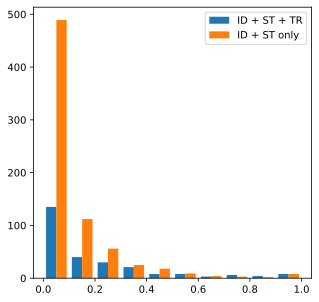

In [47]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist([
    overlap_p["id+st+tr"][overlap_p["id+st+tr"]>0],
    overlap_p["(id+st)o"][overlap_p["(id+st)o"]>0]
], label=["ID + ST + TR", "ID + ST only"])
plt.legend();

In [48]:
def plot_venn(o):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[1].set_title("Overlap distribution ({},1]".format(o))
    axes[1].hist([
        overlap_p["id+st+tr"][overlap_p["id+st+tr"]>o],
        overlap_p["(id+st)o"][overlap_p["(id+st)o"]>o]
    ], label=["ID + ST + TR", "ID + ST only"])
    axes[1].set_ylabel("n proteins")
    axes[1].set_xlabel("overlap %")
    
    axes[0].set_title("N proteins w/ overlapping (>{}%) annotations".format(int(o*100)))
    venn.venn3([set(overlap_p["id+st+tr"][overlap_p["id+st+tr"]>o].index), set(neg_mcc), set(overlap_p["(id+st)o"][overlap_p["(id+st)o"]>o].index)], 
               ["ID + ST + TR", "MCC < 0" , "ID + ST only"], ax=axes[0])
    plt.legend();
    
widgets.interactive(plot_venn, o=o)

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Min Overlap', max=1.0, step…

In [49]:
def print_proteins(o):
    lbls = ["ID + ST + TR", "MCC < 0" , "ID + ST only"]
    sets = [set(overlap_p["id+st+tr"][overlap_p["id+st+tr"]>o].index), 
            set(neg_mcc), set(overlap_p["(id+st)o"][overlap_p["(id+st)o"]>o].index)]
    
    for i, s1 in enumerate(sets):
        for j, s2 in enumerate(sets):
            if i < j:
                print("[{}] & [{}]: {}\n".format(lbls[i], lbls[j], s1 & s2))

widgets.interactive(print_proteins, o=o)                  

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Min Overlap', max=1.0, step…

In [50]:
def get_pdbs_of_uniprot(u):
    res = json.loads(requests.get("https://www.ebi.ac.uk/proteins/api/proteins/{}".format(u), headers={ "Accept" : "application/json"}).text)
    pdbs = [ref["id"] for ref in res["dbReferences"] if ref["type"] == "PDBsum"]  
    for pdb in pdbs:
        sifts = json.loads(requests.get("https://www.ebi.ac.uk/pdbe/api/mappings/{}".format(pdb)).text)
        sifts = sifts[pdb.lower()]["UniProt"][u]
        for mapping in sifts["mappings"]:
            print(u, pdb, mapping["unp_start"], mapping["unp_end"])
    return pdbs

In [51]:
uniprot_acc = "Q9NRJ3"
disprot_acc = uniprot2disprot[uniprot_acc]
uniprot_pdbs = get_pdbs_of_uniprot(uniprot_acc)

Q9NRJ3 6CWS 20 127


In [52]:
# jupyter-nbextension enable nglview --py --sys-prefix
nglview.show_pdbid(uniprot_pdbs[0], width='800px', height='400px')

NGLWidget()

In [53]:
IFrame(src='https://disprot.org/{}?release=current&show_ambiguous=true&show_obsolete=false'.format(disprot_acc),
       width='100%', height='700px')

In [54]:
p = pd.read_csv("data_big/new-disprot-all_simple.analysis.all.dataset._.predictions.csv", header=[0, 1], index_col=[0, 1])
p.loc[disprot_acc].xs('scores', axis=1, level=1).to_csv("data/{}_scores.csv".format(disprot_acc))
p = pd.read_csv("data/{}_scores.csv".format(disprot_acc), index_col=0)

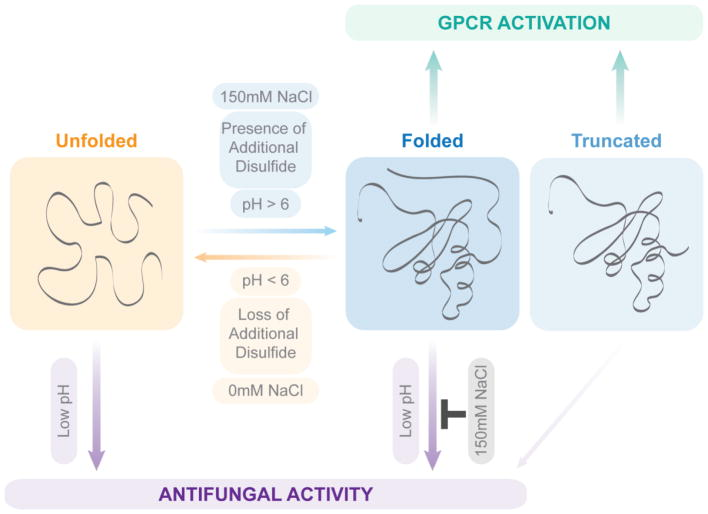

In [55]:
display(Image(filename="data/Q9NRJ3.jpg"))

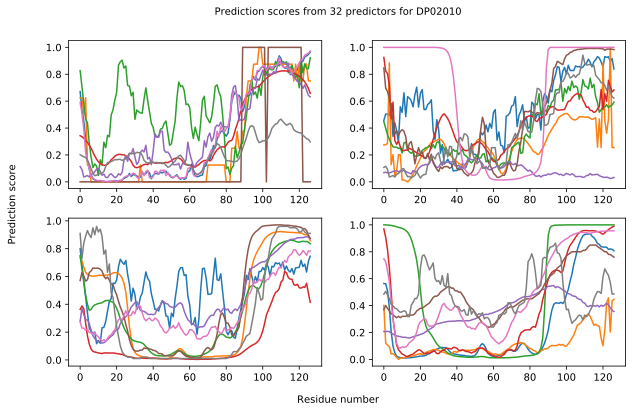

In [56]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

l = p.values.shape[1]
fig.text(0.5, 0.04, 'Residue number', ha='center')
fig.text(0.5, .94, 'Prediction scores from 32 predictors for {}'.format(disprot_acc), ha='center')
fig.text(0.04, 0.5, 'Prediction score', va='center', rotation='vertical')

for slic, ax in zip([p.loc[:, p.columns[x:x + l//4]] for x in range(0, l, l//4)], axes.flatten()):
    slic.plot(ax=ax, legend=False)